Так как сейчас в индустрии для таких задач как, детекция и сегментация наиболее актуальны билилиотеки от open-mmlab, решил использовать для этой задачи бибилиотеку mmdetection, с целью ее изучения и применения так же на текущем месте работы. 
Для запуска ноутбуков нужно установить бибилиотеку согласно инструкции https://mmdetection.readthedocs.io/en/latest/get_started.html

In [2]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
import cv2
import shutil as sh
from IPython.display import display
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import torch
import json
import mmcv
from mmengine.fileio import dump
from mmengine.utils import track_iter_progress

from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import torch
from mmengine.structures import InstanceData

# Преобразуем тренировочный датасет в более удобный формат - COCO

In [2]:
# функция преобразвания VOC аннотаций в COCO
def convert_xml_to_coco(ann_list, out_file, class_dict):

    categories = []
    for i in class_dict:
        categories.append({'id': int(class_dict[i]), 'name': i})
    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(track_iter_progress(ann_list)):
        tree = ET.parse(v)
        root = tree.getroot()
        filename = root.find('filename').text
        sz = root.find('size')
        width = int(sz.find('width').text)
        height = int(sz.find('height').text)

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))
        objs = root.findall('object')
        for obj in objs:
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = class_dict[obj.find('name').text]
            w = xmax - xmin
            h = ymax - ymin
            bbox = [xmin, ymin, w, h]

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=label,
                bbox=bbox,
                area=w*h,
                segmentation=[],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories
        )
    dump(coco_format_json, out_file)

In [3]:
# функция преобразования координат ограничивающих рамок
def xywh_to_xyxy(box):
    x0, y0, w, h = box
    return (x0, y0, x0 + w, y0 + h)

In [3]:
# создадим необходимые директории
os.mkdir('data/masks_coco')
os.mkdir('data/masks_coco/train')
os.mkdir('data/masks_coco/val')

In [4]:
# получаем список всех изображений датасета
im_list = os.listdir('../mmdetection/data/masks/images/')
im_list = ['../mmdetection/data/masks/images/'+i for i in im_list]

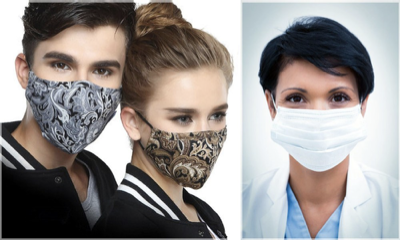

In [5]:
# посмотрим пример изображения
im = cv2.imread(im_list[0])
Image.fromarray(im[:, :, ::-1])

In [7]:
# разобьем датасет на тренировочный и валидационный
x_train, x_test = train_test_split(im_list, test_size=0.2, random_state=42)

In [34]:
# скопируем изображения в соответсвующие папки датасета в новом формате
for file in x_train:
    sh.copyfile(file, f"data/masks_coco/train/{file.split('/')[-1]}")

for file in x_test:
    sh.copyfile(file, f"data/masks_coco/val/{file.split('/')[-1]}")

In [10]:
# создадим списки тренировочных и валидационных и полный аннотаций
ann_train = [x.replace('images', 'annotations').replace('png', 'xml') for x in x_train]
ann_test = [x.replace('images', 'annotations').replace('png', 'xml') for x in x_test]
ann_list = os.listdir('../mmdetection/data/masks/annotations/')
ann_list = ['../mmdetection/data/masks/annotations/'+i for i in ann_list]

In [61]:
# создадим новые файлы аннотаций
class_list = set()
for file in ann_list:
    tree = ET.parse(file)
    root = tree.getroot()
    objs = root.findall('object')
    for obj in objs:
        class_list.add(obj.find('name').text)
        
class_dict = dict()
for i, item in enumerate(class_list):
    class_dict[item] = i


convert_xml_to_coco(ann_train, '../mmdetection/masks_coco/train.json', class_dict)
convert_xml_to_coco(ann_test, '../mmdetection/masks_coco/val.json', class_dict)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 682/682, 2002.4 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 171/171, 2896.9 task/s, elapsed: 0s, ETA:     0s


In [62]:
class_dict

{'mask_weared_incorrect': 0, 'without_mask': 1, 'with_mask': 2}

### Ноутбуки с тренировкой моделей находятся в папках fasterRCNN и yolox

Модель семейства yolo выбрал yolox, потому что в библиотеке mmdetection представлены только yolo3 и yolox. yolo3 отмел как довольно устаревшую, по моему мнению, не способную достичь требуемой точности.
FasterRCNN удалось обучить до mAP 0.85 за 5 эпох, но при пороге IoU только лишь 0.01, а yolox за 151 эпоху при пороге 0.55. Вообще, двухстадийные модели показывают лучший результат, чам одностадийные, однако тут yolox сильно более современная, чем fasterRCNN, поэтому она показывает несколько лучше результат, правда обучалась большее количество эпох. Однако fasterRCNN каждую эпоху тренировочный датасет прогонала по три раза и в целом сильно дольше одна эпоха тренировалась. Так же, на инференсе yolox сильно опережает по скорости fasterRCNN.

#### Некоторые метрики при тренировке fasterRCNN

![подпись](./fasterRCNN/acc_mAP.png)

![подпись](./fasterRCNN/mAP50.png)

![подпись](./fasterRCNN/train_loss1.png)

![подпись](./fasterRCNN/train_loss2.png)

![подпись](./fasterRCNN/val_loss1.png)

![подпись](./fasterRCNN/val_loss2.png)

Как видно, на треине лосс снижается, однако валидационном датасете лосс в какой то момент сильно растет, видимо идет переобучение, однако лучший результат был на 5-й эпохе, там различие лоссов на треине и валидационной выборке не очень большое. Так как результат был достигнут, эксперименты закончил, однако можно еще поэксперементировать с добавлением дополнительных аугментаций, или изменить оптимизатор.

#### Некоторые метрики при тренировке YoloX

![подпись](./yolox/mAP.png)

![подпись](./yolox/mAP50.png)

![подпись](./yolox/train_loss1.png)

![подпись](./yolox/train_loss2.png)

![подпись](./yolox/val_loss1.png)

![подпись](./yolox/val_loss2.png)

Тут, как видно, разница в значении лосса на треине и валидации очень большая. Однако тут используется довольно хорошая аугментация  - мозаичная, я бы не стал добавлять что то другое. Можно попробовать посмотреть на так называемые Hard Examples, посмотреть в чем причина ошибки на этих изображениях и как минимум добавить больше идентичных изображений. Однако результат достигнут и дальнейшие исследования решил не прдолжать.